The objective of this notebook is the same as the "learning_from_intervals" one with the use of neural networks

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator

from typing import Tuple

# Load dataset

In [2]:
def load_planar_dataset(n_example: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create and return a mock dataset. If we plot the data, we can see
    a sort of flower. The created dataset contains n_example X of 2 features
    and their associated label

    Args:
        n_example (int): number of examples in the wanted dataset

    Returns:
        Tuple[np.ndarray, np.ndarray]: Features matrix and associated labels vector
    """
    np.random.seed(1)
    n_representation = int(n_example/2)
    n_features = 2
    features = np.zeros((n_example, n_features))
    labels = np.zeros((n_example,1), dtype='uint8')
    max_ray = 4
    for label in range(2):
        index = range(n_representation*label,n_representation*(label+1))
        theta = np.linspace(
            label*3.12,(label+1)*3.12,n_representation
        ) + np.random.randn(n_representation)*0.2
        radius = max_ray*np.sin(4*theta) + np.random.randn(n_representation)*0.2
        features[index] = np.c_[radius*np.sin(theta), radius*np.cos(theta)]
        labels[index] = label
    return features, labels

In [3]:
X, Y = load_planar_dataset(n_example=4000)
df = pd.DataFrame(X, columns=["X1", "X2"])
df["Y"] = Y
df.head()

,X1,X2,Y
0,1.261282,3.744878,0
1,0.218168,-1.797375,0
2,0.172355,-1.675405,0
3,0.645912,-3.031743,0
4,0.396580,2.187762,0


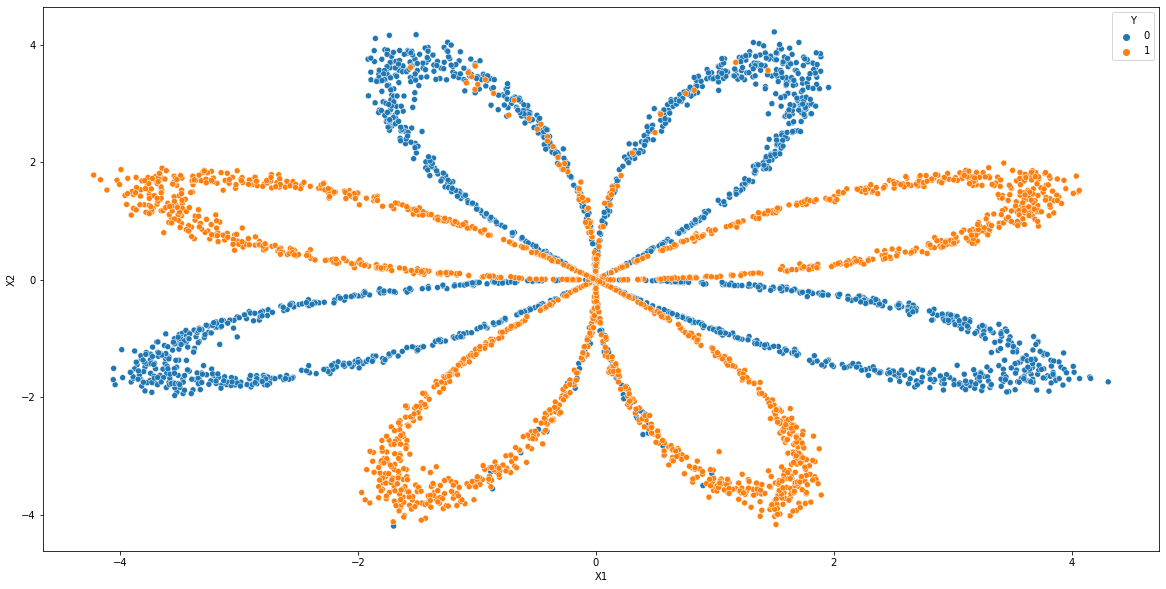

In [4]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="Y")
plt.show()

In [5]:
df2 = pd.read_csv("../data/SynthPara_n1000_p2.csv")
df2["y"] = df2["z"].apply(lambda x: 0 if x == "B" else 1)
df2.head()

,X1,X2,z,y
0,3.119353,7.100552,B,0
1,-3.850261,-4.934919,A,1
2,-4.214494,-7.396423,A,1
3,3.197394,4.783222,B,0
4,-4.296943,-4.839382,A,1


In [6]:
def transform_to_interval(variable: str) -> np.ndarray:
    """
    Transform a hard label into an interval of probabilities.
    If the label is 0, the created interval will be in the range of
    [0, 0.49], else it will be in the range of [0.5, 1]
    
    Args:
        variable (int): variable to transform
    
    Returns:
        (np.ndarray): created interval 
    """
    if variable == "B":
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.0,
                    high=0.49,
                    size=(2,)
                ),
                decimals=2
            )
        )
    else:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.5,
                    high=1.0,
                    size=(2,)
                ),
                decimals=2
            )
        )
    return interval

In [7]:
df2["interval"] = df2["z"].apply(transform_to_interval)
df2.head()

,X1,X2,z,y,interval
0,3.119353,7.100552,B,0,"[0.2, 0.22]"
1,-3.850261,-4.934919,A,1,"[0.71, 0.81]"
2,-4.214494,-7.396423,A,1,"[0.65, 0.95]"
3,3.197394,4.783222,B,0,"[0.21, 0.34]"
4,-4.296943,-4.839382,A,1,"[0.73, 0.75]"


In [8]:
def get_classical_model():
    tf.random.set_seed(1)
    inputs = keras.Input(shape=(2, ), name="Input_layer")
    outputs = layers.Dense(units=1, activation="sigmoid", name="Outputs_connected_with_second_layer")(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="first_test")
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"], optimizer='sgd')
    return model

2022-09-25 05:00:03.480317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


32/32 [==============================] - 0s 882us/step


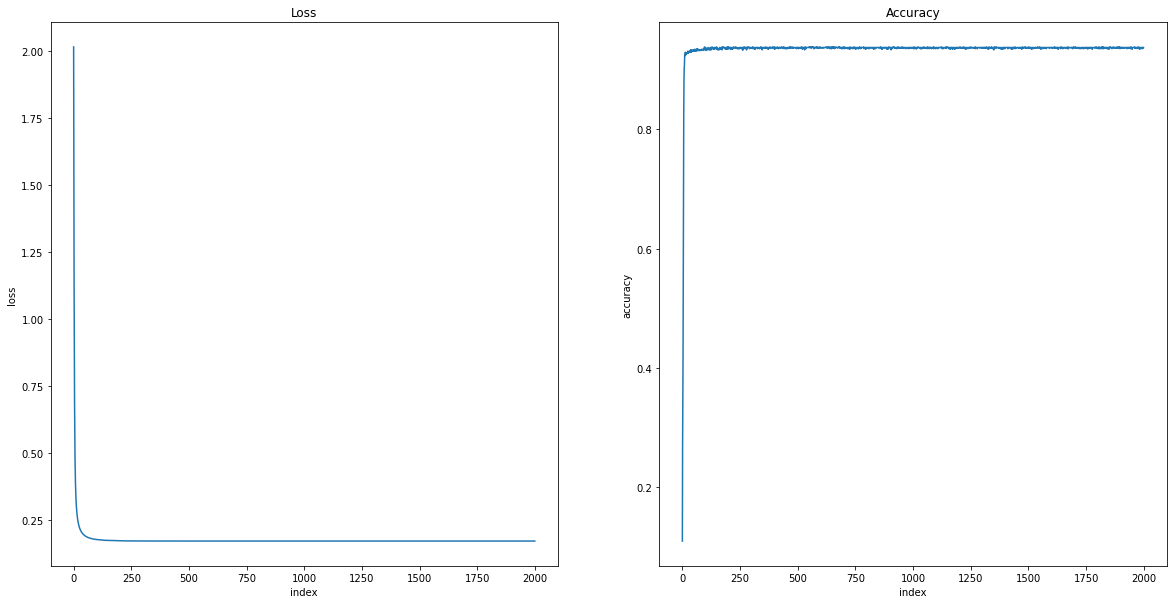

In [9]:
m1 = get_classical_model()
history = m1.fit(df2[["X1", "X2"]], df2["y"], epochs=2000, verbose=False)
df2["predictions"] = m1.predict(df2[["X1", "X2"]])
df2["predictions"] = df2["predictions"].apply(lambda x: 1 if x >=0.5 else 0)
history = pd.DataFrame(history.history).reset_index()
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(data=history, x='index', y="loss", ax=axes[0]).set(title="Loss")
sns.lineplot(data=history, x='index', y="accuracy", ax=axes[1]).set(title="Accuracy")
plt.show()

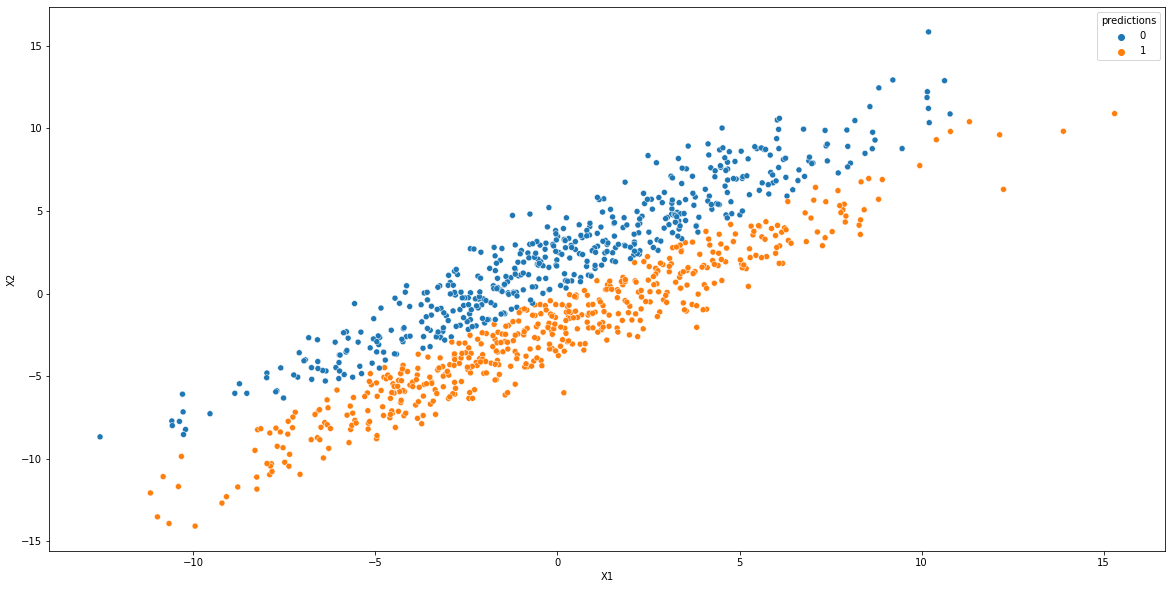

In [10]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df2, x="X1", y="X2", hue="predictions")
plt.show()

In [13]:
def get_model_with_kl_divergence():
    tf.random.set_seed(1)
    inputs = keras.Input(shape=(2, ), name="Input_layer")
    outputs = layers.Dense(units=1, activation="sigmoid", name="Outputs_connected_with_second_layer")(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="first_test")
    model.compile(optimizer="sgd", loss=tf.keras.losses.KLD, metrics=["accuracy"])
    return model

32/32 [==============================] - 0s 893us/step


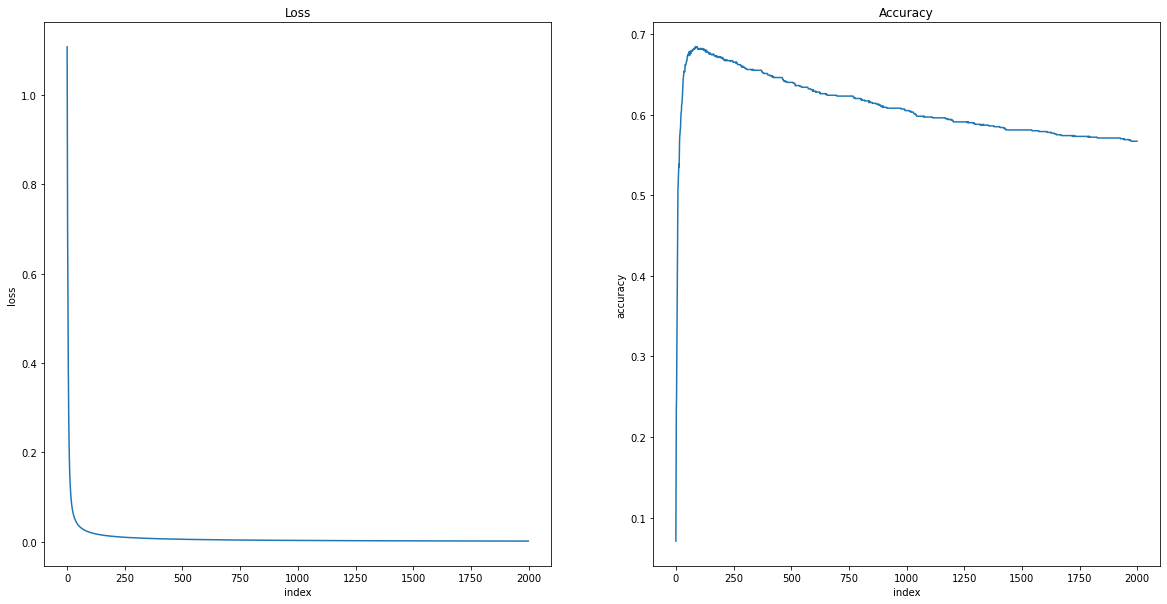

In [14]:
m2 = get_model_with_kl_divergence()
history = m2.fit(df2[["X1", "X2"]], df2["y"], epochs=2000, verbose=False)
df2["predictions2"] = m2.predict(df2[["X1", "X2"]])
df2["predictions2"] = df2["predictions2"].apply(lambda x: 1 if x >=0.5 else 0)
history = pd.DataFrame(history.history).reset_index()
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(data=history, x='index', y="loss", ax=axes[0]).set(title="Loss")
sns.lineplot(data=history, x='index', y="accuracy", ax=axes[1]).set(title="Accuracy")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df2, x="X1", y="X2", hue="predictions2")
plt.show()